In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [15]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out import create_dir
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs

from geo_tool import Point_Cloud

from tf_lab.in_out.basics import Data_Splitter
from tf_lab.point_clouds.ae_templates import conv_architecture_ala_nips_17, default_train_params_ala_nips_17
from tf_lab.point_clouds.encoders_decoders import encoder_with_convs_and_symmetry, decoder_with_fc_only, encoder_with_convs_and_symmetry_new
from tf_lab.point_clouds.autoencoder import Configuration as Conf
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder

from tf_lab.point_clouds.in_out import load_point_clouds_from_filenames, PointCloudDataSet
from tf_lab.data_sets.shape_net import pc_loader as snc_loader
from tf_lab.data_sets.shape_net import snc_category_to_synth_id
from tflearn.layers.conv import avg_pool_1d
from pc_completions.evaluation import basic_comletion_measures


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
n_pc_points = 2048
top_data_dir = '/orions4-zfs/projects/optas/DATA/'
top_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_points))

In [5]:
train_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/single_class_splits/03001627/85_5_10/train.txt')
val_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/single_class_splits/03001627/85_5_10/val.txt')
test_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/single_class_splits/03001627/85_5_10/test.txt')

# train_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/wu_medium_size_splits/train.txt')
# val_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/wu_medium_size_splits/val.txt')
# test_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/wu_medium_size_splits/test.txt')

# train_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/wu_small_size_splits/train.txt')
# val_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/wu_small_size_splits/val.txt')
# test_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/wu_small_size_splits/test.txt')

In [6]:
do_training = True
load_pretrained_model = False
load_epoch = None
random_seed = 42
loss = 'chamfer'
bneck_size = 32

In [7]:
splitter = Data_Splitter(top_pclouds_path, data_file_ending='.ply', random_seed=random_seed)

tr_files = splitter.load_splits(train_split)
pclouds, model_ids, syn_ids = load_point_clouds_from_filenames(tr_files, n_threads=20, loader=snc_loader, verbose=True)
train_data = PointCloudDataSet(pclouds, labels=syn_ids + '_' + model_ids)

val_files = splitter.load_splits(val_split)
pclouds, model_ids, syn_ids = load_point_clouds_from_filenames(val_files, n_threads=20, loader=snc_loader, verbose=True)
val_data = PointCloudDataSet(pclouds, labels=syn_ids + '_' + model_ids)

test_files = splitter.load_splits(test_split)
pclouds, model_ids, syn_ids = load_point_clouds_from_filenames(test_files, n_threads=20, loader=snc_loader, verbose=True)
val_data = PointCloudDataSet(pclouds, labels=syn_ids + '_' + model_ids)

5761 pclouds were loaded. They belong in 1 shape-classes.
338 pclouds were loaded. They belong in 1 shape-classes.
679 pclouds were loaded. They belong in 1 shape-classes.


In [29]:
b_norm = True

decoder_args = {'layer_sizes': [bneck_size, 256, 512, n_pc_points*3], 'b_norm': b_norm}

encoder_args = {'n_filters': [64, 128, 128, 256],
                'filter_sizes': [9, 3, 2, 2],
                'strides': [1, 1, 1, 1],
                'b_norm': b_norm,
                'pool': avg_pool_1d,
                'pool_sizes': [8, 4, 2, 2],
                'symmetry': None
                }

In [30]:
v = 1
v = str(v)
bneck_size = 32

In [31]:
experiment_id = 'neighborhood_size_v_' + v
experiment_name = '_'.join(['chair', 'exp', experiment_id, str(n_pc_points),
                            'pts_bneck', str(bneck_size), loss
                           ])

train_dir = osp.join(top_data_dir, 'OUT/iclr/nn_models/testing_ae_settings', experiment_name)
create_dir(train_dir)

'/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/testing_ae_settings/chair_exp_neighborhood_size_v_1_2048_pts_bneck_32_chamfer'

In [32]:
if load_pretrained_model:
    conf = Conf.load(osp.join(train_dir, 'configuration'))
    print conf
    if conf.train_dir != train_dir:
        conf.train_dir = train_dir
    conf.save(osp.join(train_dir, 'configuration'))
else:
    conf = Conf(
                n_input = [n_pc_points, 3],
                loss = loss,
                training_epochs = 250,
                batch_size = 50,
                denoising = False,
                learning_rate = 0.0005,
                train_dir = train_dir,             
                loss_display_step = 1,
                saver_step = None,
                z_rotate = False,
                encoder = encoder_with_convs_and_symmetry_new, 
                decoder = decoder_with_fc_only,
                encoder_args = encoder_args,
                decoder_args = decoder_args
               )
    
    conf.experiment_name = experiment_name
    conf.held_out_step = 5
    conf.save(osp.join(conf.train_dir, 'configuration'))

In [33]:
reset_tf_graph()
ae = PointNetAutoEncoder(conf.experiment_name, conf)
print ae.trainable_parameters()

Tensor("chair_exp_neighborhood_size_v_1_2048_pts_bneck_32_chamfer_1/AvgPool1D/Squeeze:0", shape=(?, 256, 64), dtype=float32) 16384
Tensor("chair_exp_neighborhood_size_v_1_2048_pts_bneck_32_chamfer_1/AvgPool1D_1/Squeeze:0", shape=(?, 64, 128), dtype=float32) 8192
Tensor("chair_exp_neighborhood_size_v_1_2048_pts_bneck_32_chamfer_1/AvgPool1D_2/Squeeze:0", shape=(?, 32, 128), dtype=float32) 4096
Tensor("chair_exp_neighborhood_size_v_1_2048_pts_bneck_32_chamfer_1/AvgPool1D_3/Squeeze:0", shape=(?, 16, 256), dtype=float32) 4096
3550944


In [34]:
if do_training:
    buf_size = 1 # flush each line
    fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)    
    train_stats = ae.train(train_data, conf, log_file=fout, held_out_data=val_data)
    fout.close()

('Epoch:', '0001', 'training time (minutes)=', '0.0631', 'loss=', '0.007351347')
('Epoch:', '0002', 'training time (minutes)=', '0.0457', 'loss=', '0.003011111')
('Epoch:', '0003', 'training time (minutes)=', '0.0433', 'loss=', '0.002788776')
('Epoch:', '0004', 'training time (minutes)=', '0.0505', 'loss=', '0.002518948')
('Epoch:', '0005', 'training time (minutes)=', '0.0441', 'loss=', '0.002416768')
('Held Out Data :', 'forward time (minutes)=', '0.0020', 'loss=', '0.002109449')
('Epoch:', '0006', 'training time (minutes)=', '0.0484', 'loss=', '0.002314324')
('Epoch:', '0007', 'training time (minutes)=', '0.0457', 'loss=', '0.002179938')
('Epoch:', '0008', 'training time (minutes)=', '0.0443', 'loss=', '0.002129608')
('Epoch:', '0009', 'training time (minutes)=', '0.0485', 'loss=', '0.002062138')
('Epoch:', '0010', 'training time (minutes)=', '0.0515', 'loss=', '0.001946232')
('Held Out Data :', 'forward time (minutes)=', '0.0013', 'loss=', '0.001789977')
('Epoch:', '0011', 'training

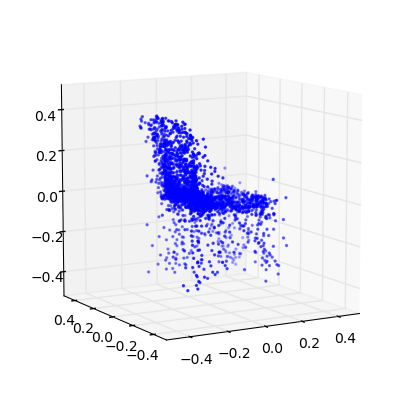

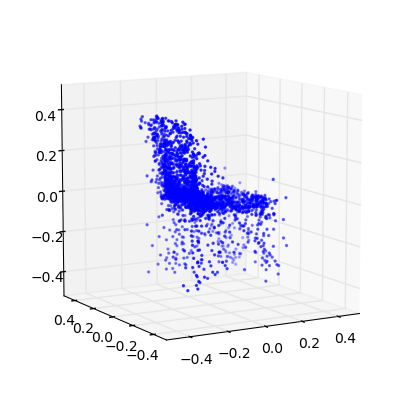

In [165]:
Point_Cloud(ae.reconstruct(np.expand_dims(train_data.point_clouds[0], 0))[0][0]).plot()